# Humpback Whale Identification Challenge

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [3]:
torch.cuda.is_available()

False

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
PATH = "data/"

## Exploring the dataset

In [6]:
! ls {PATH}

models		       test.zip  train.csv
sample_submission.csv  tmp	 traing_data_without_new_whale.csv
test		       train	 train.zip


In [7]:
training_data = pd.read_csv(f'{PATH}train.csv')
training_data.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [8]:
training_data.shape

(9850, 2)

In [9]:
#traing_data_without_new_whale = training_data[training_data['Id'] != "new_whale"]
#traing_data_without_new_whale.to_csv(f'{PATH}traing_data_without_new_whale.csv', index=False)
traing_data_without_new_whale = pd.read_csv(f'{PATH}traing_data_without_new_whale.csv')
traing_data_without_new_whale.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [10]:
print('Number of traing images %s' % len(os.listdir(f'{PATH}train'))) 
print('Number of test images %s' % len(os.listdir(f'{PATH}test'))) 

Number of traing images 9850
Number of test images 15610


So, the number of test images is way more than number of traing images.

In [11]:
def plot_images_for_filenames(filenames, labels, rows=4):
    imgs = [plt.imread(f'{PATH}train/{filename}') for filename in filenames]
    
    return plot_images(imgs, labels, rows)
    
        
def plot_images(imgs, labels, rows=4):
    # Set figure to 13 inches x 8 inches
    figure = plt.figure(figsize=(13, 8))

    cols = len(imgs) // rows + 1

    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=16)
        plt.imshow(imgs[i], cmap='gray')        

In [12]:
np.random.seed(42)

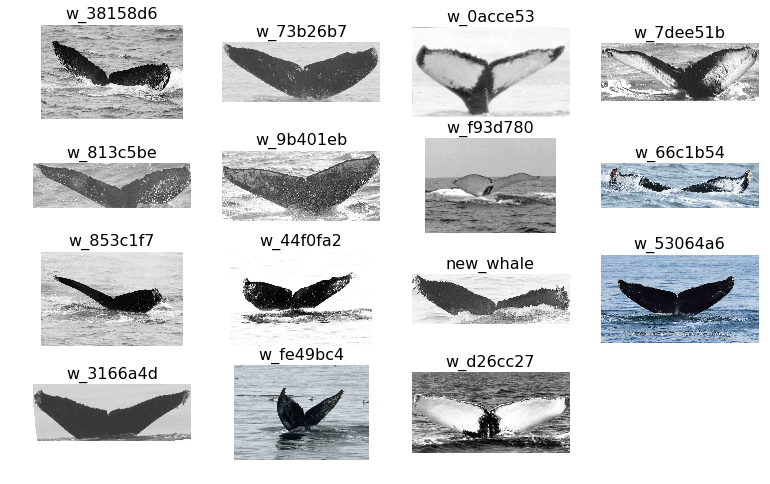

In [13]:
rand_rows = training_data.sample(frac=1.)[:15]
imgs = list(rand_rows['Image'])
labels = list(rand_rows['Id'])

plot_images_for_filenames(imgs, labels)

Let's take a look at the breakdown of number of image per category.

In [14]:
print("Number of categories: %s" % len(training_data['Id'].unique()))

Number of categories: 4251


There appear to be too many categories to graph count by category, so let's instead graph the number of categories by the number of images in the category.

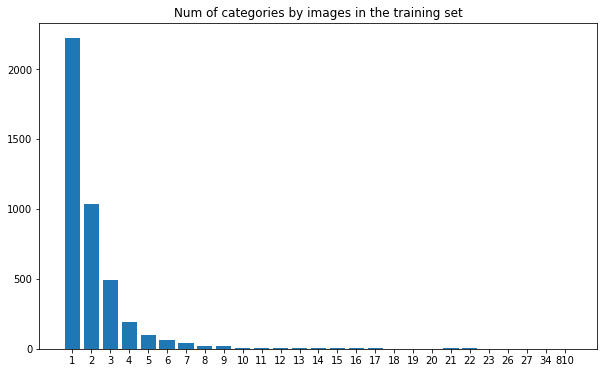

In [15]:
size_buckets = Counter(training_data['Id'].value_counts().values)

plt.figure(figsize=(10, 6))
plt.bar(range(len(size_buckets)), list(size_buckets.values())[::-1], align='center')
plt.xticks(range(len(size_buckets)), list(size_buckets.keys())[::-1])
plt.title("Num of categories by images in the training set")
plt.show()

So it seems a vast majority of classes only have a single image in them

In [16]:
training_data['Id'].value_counts().head(10)

new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
w_693c9ee     22
w_ab4cae2     22
w_fd1cb9d     22
w_73d5489     21
w_43be268     21
Name: Id, dtype: int64

In [17]:
def is_grey_scale(img_path):
    """Thanks to https://stackoverflow.com/questions/23660929/how-to-check-whether-a-jpeg-image-is-color-or-gray-scale-using-only-python-stdli"""
    im = Image.open(img_path).convert('RGB')
    w,h = im.size
    for i in range(w):
        for j in range(h):
            r,g,b = im.getpixel((i,j))
            if r != g != b: return False
    return True

In [18]:
is_grey = [is_grey_scale(f'{PATH}train/{i}') for i in training_data['Image'].sample(frac=0.1)]
grey_perc = round(sum([i for i in is_grey]) / len([i for i in is_grey]) * 100, 2)
print(f"% of grey images: {grey_perc}")

% of grey images: 47.31


As only half of the images are grey scale I think it would be good idea to transform gray scale images into black and white images.

It might also be worth capturing the size of the images so we can get a sense of what we're dealing with.

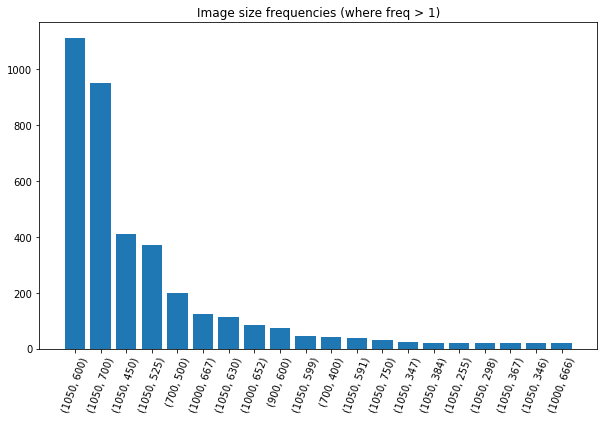

In [19]:
img_sizes = Counter([Image.open(f'{PATH}train/{i}').size for i in training_data['Image']])

size, freq = zip(*Counter({i: v for i, v in img_sizes.items() if v > 1}).most_common(20))

plt.figure(figsize=(10, 6))

plt.bar(range(len(freq)), list(freq), align='center')
plt.xticks(range(len(size)), list(size), rotation=70)
plt.title("Image size frequencies (where freq > 1)")

plt.show()

## Building initial model

In [20]:
sz=64
arch=resnet34
bs=64

label_csv = f'{PATH}traing_data_without_new_whale.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [21]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.05)
    data= ImageClassifierData.from_csv(PATH, 'train', f'{PATH}traing_data_without_new_whale.csv', tfms=tfms,
                    val_idxs=val_idxs, test_name='test', bs=bs)
    return data #if sz>300 else data.resize(340, 'tmp') 

In [22]:
data = get_data(sz, bs)
fn = PATH+data.trn_ds.fnames[0]; fn

'data/train/000466c4.jpg'

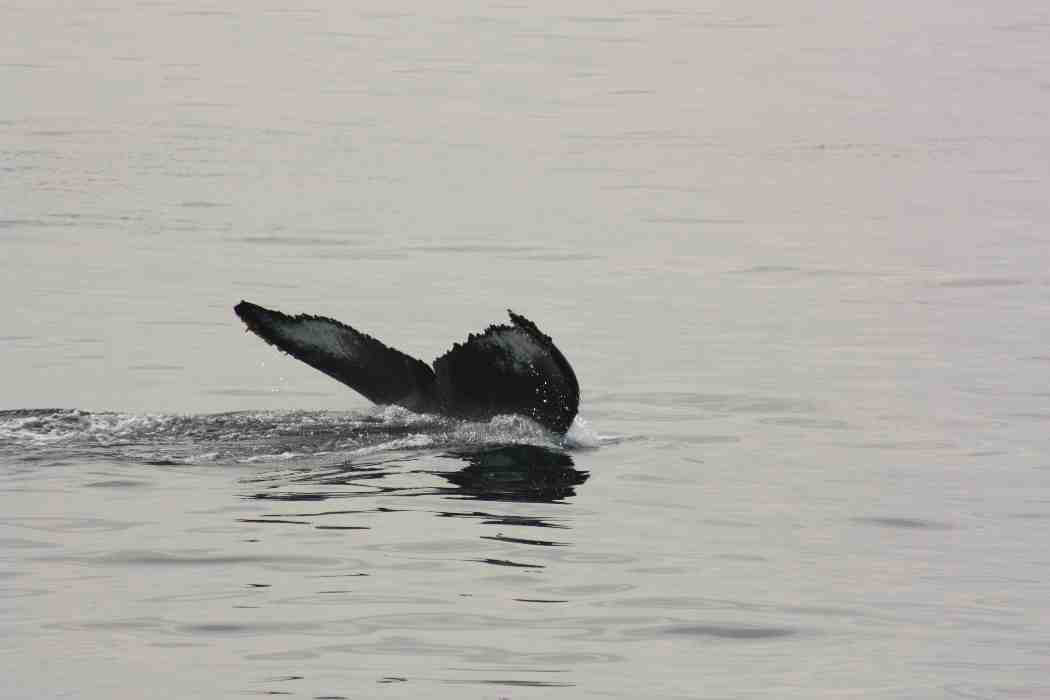

In [23]:
img = PIL.Image.open(fn); img

In [24]:
print(img.size)
data.c

(1050, 700)


4250

In [25]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [26]:
learn.model

Sequential(
  (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=4250, bias=True)
  (7): LogSoftmax()
)

 98%|█████████▊| 111/113 [00:06<00:00, 17.25it/s, loss=48.6]


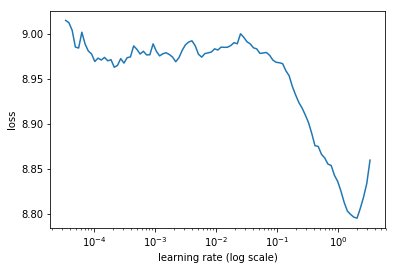

In [27]:
lrf=learn.lr_find()
learn.sched.plot()

In [28]:
lr = 0.05

In [42]:
learn.fit(lr, 3, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                   
    0      3.243768   7.986153   0.128872  
    1      2.233897   8.059109   0.13385                    
    2      2.452925   8.363126   0.134403                   
    3      1.616585   8.383952   0.14104                    
    4      1.834719   8.682426   0.141593                   
    5      1.190442   8.669865   0.144912                   



[array([8.66987]), 0.14491150442477876]

In [30]:
log_pred,y = learn.TTA()

In [31]:
probs = np.mean(np.exp(log_pred),0)
print("Log prediction shape***************** ", log_pred.shape)
print("Probability shape**************** ", probs.shape)
print("Number of output classes********* ", len(data.classes))

Log prediction shape*****************  (5, 1808, 4250)
Probability shape****************  (1808, 4250)
Number of output classes*********  4250


In [49]:
data.test_ds.fnames[0][5:]

'test/a779821d.jpg'

In [41]:
log_pred = learn.predict()
probs = np.exp(log_pred)
probs.shape

(1808, 4250)

In [48]:
data.classes

['w_0013924',
 'w_001ebbc',
 'w_002222a',
 'w_002b682',
 'w_002dc11',
 'w_0087fdd',
 'w_008c602',
 'w_009dc00',
 'w_00b621b',
 'w_00c4901',
 'w_00cb685',
 'w_00d8453',
 'w_00fbb4e',
 'w_0103030',
 'w_010a1fa',
 'w_011d4b5',
 'w_0122d85',
 'w_01319fa',
 'w_0134192',
 'w_013bbcf',
 'w_014250a',
 'w_014a645',
 'w_0156f27',
 'w_015c991',
 'w_015e3cf',
 'w_01687a8',
 'w_0175a35',
 'w_018bc64',
 'w_01a4234',
 'w_01a51a6',
 'w_01a99a5',
 'w_01ab6dc',
 'w_01b2250',
 'w_01c2cb0',
 'w_01cbcbf',
 'w_01d6ca0',
 'w_01e1223',
 'w_01f211f',
 'w_01f8a43',
 'w_01f9086',
 'w_024358d',
 'w_0245a27',
 'w_0265cb6',
 'w_026fdf8',
 'w_028ca0d',
 'w_029013f',
 'w_02a768d',
 'w_02b775b',
 'w_02bb4cf',
 'w_02c2248',
 'w_02c9470',
 'w_02cf46c',
 'w_02d5fad',
 'w_02d7dc8',
 'w_02e5407',
 'w_02facde',
 'w_02fce90',
 'w_030294d',
 'w_0308405',
 'w_0324b97',
 'w_032d44d',
 'w_0337aa5',
 'w_034a3fd',
 'w_0378699',
 'w_037955e',
 'w_03a2ed7',
 'w_03b5e9a',
 'w_03c6d18',
 'w_03c84ef',
 'w_03dc41c',
 'w_03ed3de',
 'w_03

## Preparing for the Kaggle submission

In [74]:
submission_df = pd.DataFrame(columns=['Image','Id'])
submission_df.head()

,Image,Id


In [75]:
for im,row in zip(data.test_ds.fnames,probs):
    pred_row = np.argsort(-row)[:4]
    str="new_whale"
    for i in pred_row:
        str = str+" "+data.classes[i]
    submission_df.loc['Image']=im[5:]
    submission_df.loc['Id']=str    

In [76]:
submission_df

,Image,Id
Image,c2aca18f.jpg,c2aca18f.jpg
Id,new_whale w_2dcbf82 w_cce912e w_8d46cef w_28ce17c,new_whale w_2dcbf82 w_cce912e w_8d46cef w_28ce17c
